# Assignment on Decision Trees for Heart Failure data

For this assignment we will be predicting the mortality by heart failure from different physiological variables using both parametric and non-parametric models. The variables of this dataset are as follows

- `age`: age of the patient (years)
- `anaemia`: decrease of red blood cells or - hemoglobin (boolean)
- `cpk`: level of the CPK enzyme in the blood (mcg/L)
- `diabetes`: if the patient has diabetes (boolean)
- `ef`: ejection fraction: percentage of blood leaving the heart at each contraction
- `hbp`: if the - patient has hypertension (boolean)
- `platelets`: platelets in the blood (kiloplatelets/mL)
- `sc`: level of serum creatinine in the blood (mg/dL)
- `ss`: level of serum sodium in the blood (mEq/L)
- `sex`: female/male (binary)
- `smoking`: if the patient smokes or not (boolean)
- `fup`: follow-up period (days)
- `death_event`: the patient deceased during the follow-up period (boolean)

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("HFCRD.csv")
data.shape

(299, 13)

In [3]:
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


### 1. Exploratory Data Analysis

Notice we have 13 variables on 299 entries and there are no missing values.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
data['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

Regarding the dataset imbalance, the survived patients represent the $67.9\%$ of total patients while the non-surviving patients are the remaining $32.1\%$ of patients. As such, the classes to be predicted are not completely balanced in terms of frequency, but the imbalance is not critically undesirable. At some point we will stratify the data according to this variable for a coherent cross-validation procedure.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
pca.fit_transform(data)
print(pca.explained_variance_ratio_)

[9.99900987e-01 9.83521117e-05 6.30369253e-07 1.53058705e-08
 1.31726388e-08]


Observe how just the first principal component already explains more than 99% of the variance in the dataset. That being said, most of the variables are boolean, but still it indicates the strong relationship among the variables with each other. In fact, the `fup` variable is highly correlated with our response and is causally related to it as a successor random variable. What this means is that a death event has a causal effect with the follow-up time, and therefore we shall remove it from the study and from the successive models.

In [8]:
pca = PCA(n_components = 5)
pca.fit_transform(data.drop('time', axis=1))
print(pca.explained_variance_ratio_)

[9.99901616e-01 9.83521152e-05 1.55019261e-08 1.37707478e-08
 1.94730183e-09]


## 2. Train-Test Partition

In [9]:
from sklearn.model_selection import train_test_split

np.random.seed(123)

input = data.drop(['DEATH_EVENT','time'], axis=1)
target = data['DEATH_EVENT']

train_input, test_input, train_target, test_target = train_test_split(input, target, test_size = 1/3, stratify = target)

In [10]:
print(train_input.shape, train_target.shape, test_input.shape, test_target.shape)

(199, 11) (199,) (100, 11) (100,)


In [11]:
display(train_target.value_counts())
display(test_target.value_counts())

0    135
1     64
Name: DEATH_EVENT, dtype: int64

0    68
1    32
Name: DEATH_EVENT, dtype: int64

We can see how the target classes are well partitioned among the train and test splits, as per the stratification parameter.

## 3. Fitting Statistical Models

We will now be fitting the available data using three different statistical models
- A *decision tree* to predcit survival (encoded in `death_event`)
- A *logistic* classifier to predict survival
- (To be decided by us)

To do so, we will be using functions from the `scikit` and `sklearn` libraries. The documentation can be found at https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

### 3.1. Decision Tree

Starting off with the nonparametric decision tree, using `sklearn` we shall fit a naive model, and then tune it via pruning and validation to select the best possible model. Then, a graphical representation of the tree along with its performance metrics will be provided.

In [12]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

clf_naive = tree.DecisionTreeClassifier(criterion='log_loss', min_samples_leaf=10, max_depth=20, random_state=0)
clf_naive = clf_naive.fit(train_input, train_target)

In [13]:
from sklearn.metrics import accuracy_score
print("Training accuracy:", accuracy_score(train_target, clf_naive.predict(train_input)))

Training accuracy: 0.8341708542713567


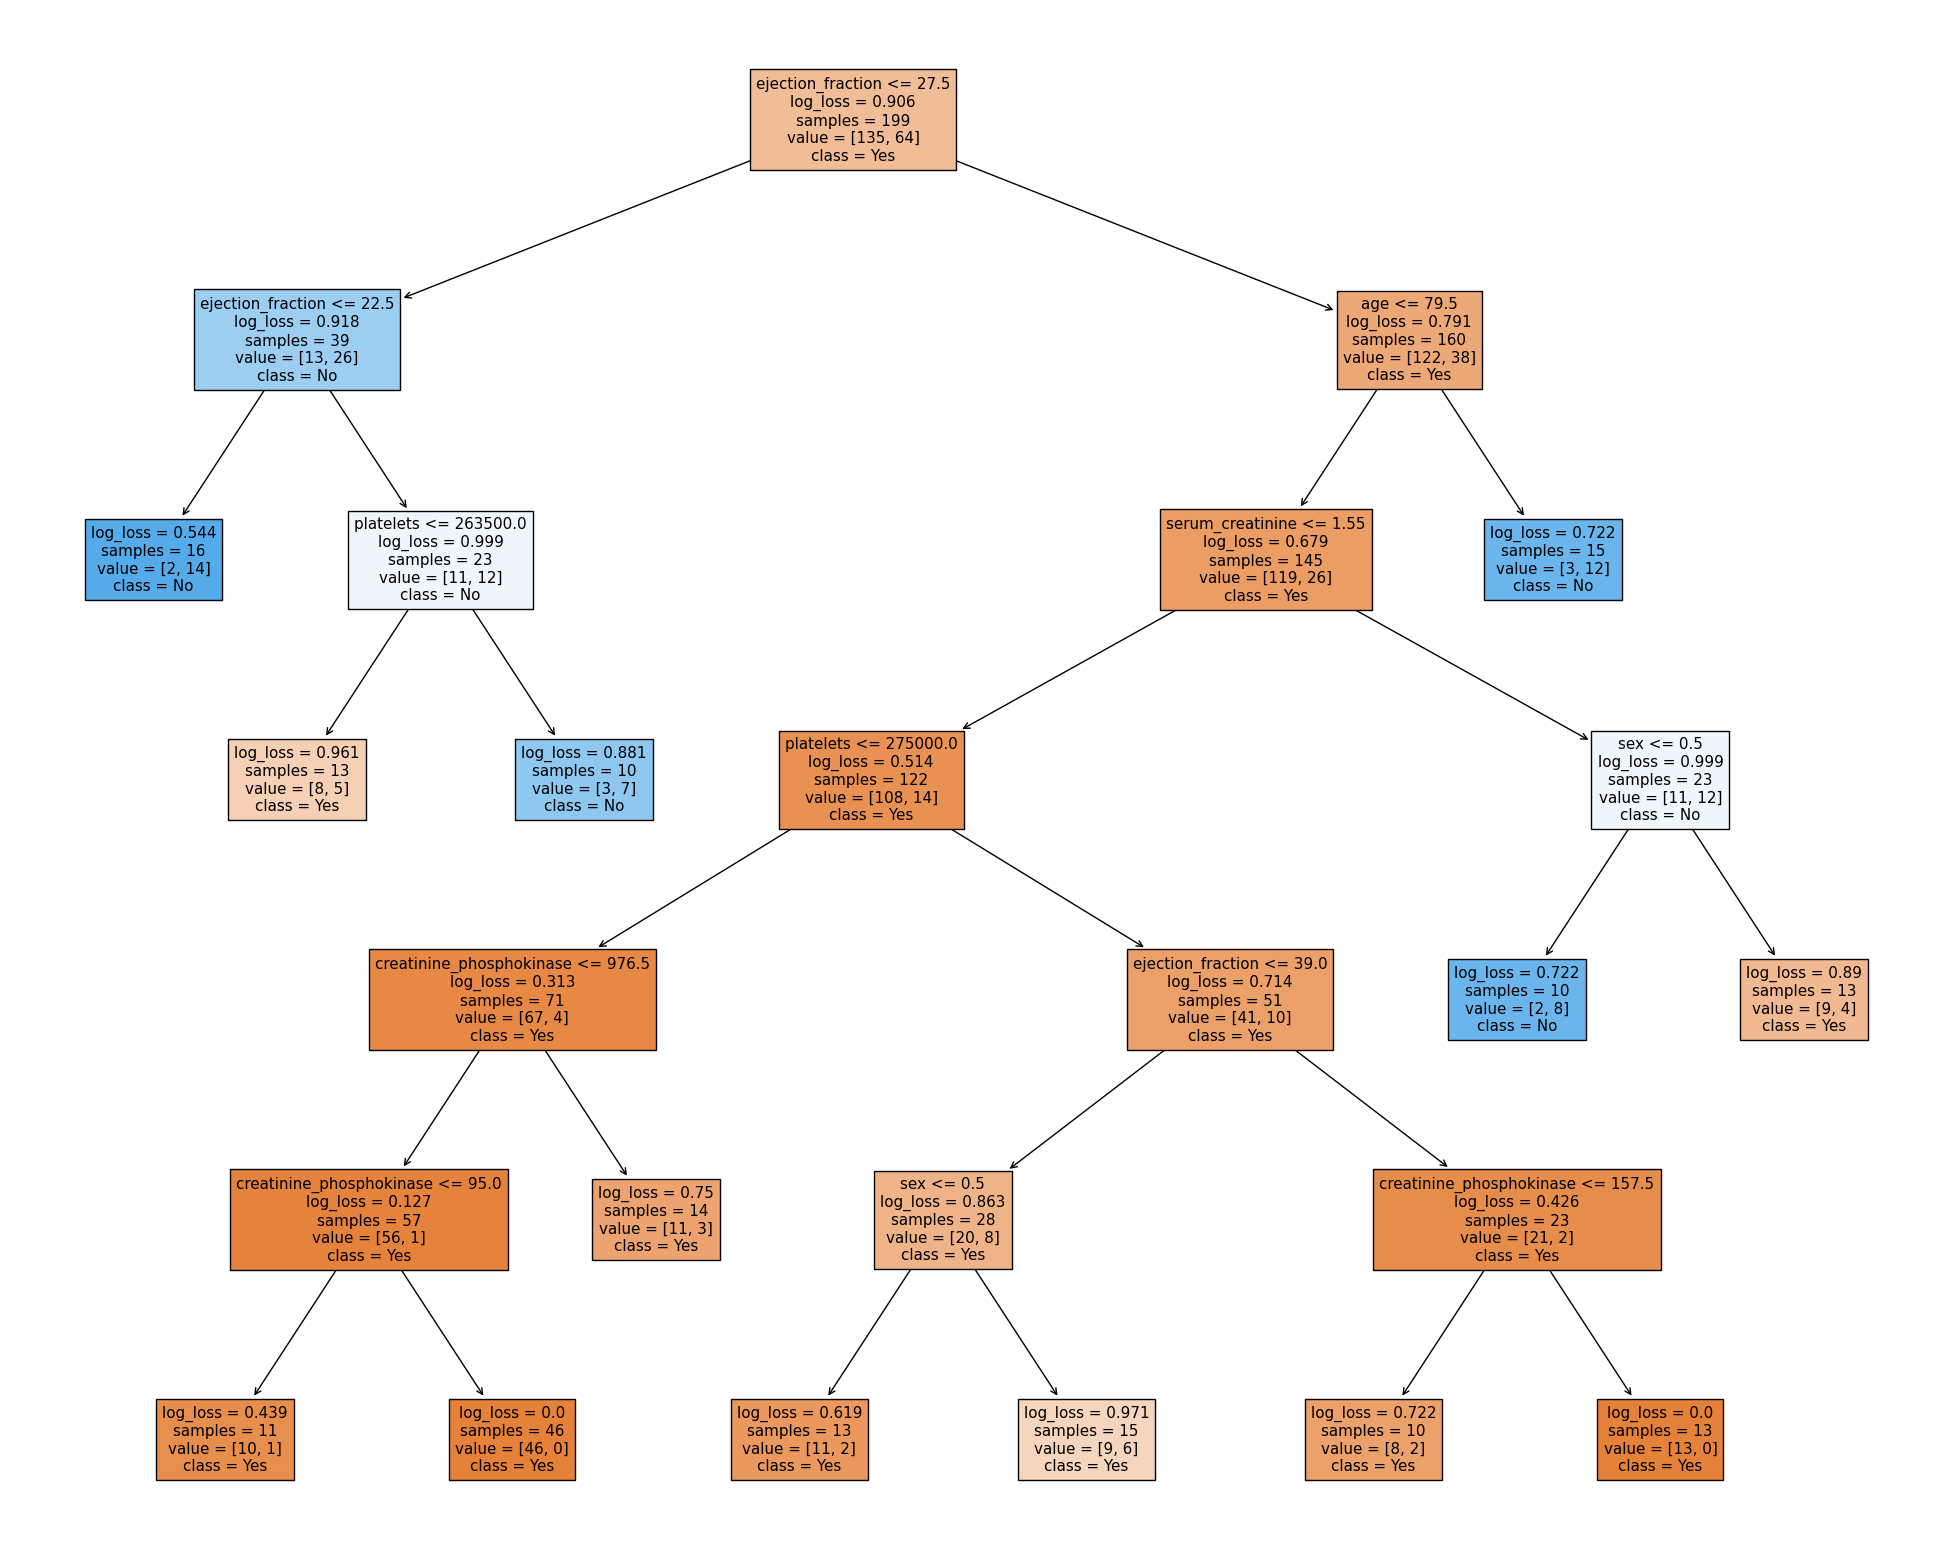

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_naive, 
                   feature_names=train_input.columns,  
                   class_names=['Yes', 'No'],
                   filled=True)

In [15]:
importances = pd.DataFrame({'Predictor' : data.drop(columns = ['time', 'DEATH_EVENT']).columns,
              'Importance': clf_naive.feature_importances_})

importances.sort_values('Importance', ascending=False)

,Predictor,Importance
4,ejection_fraction,0.325190
0,age,0.229284
7,serum_creatinine,0.168217
2,creatinine_phosphokinase,0.125249
6,platelets,0.076267
9,sex,0.075793
1,anaemia,0.000000
3,diabetes,0.000000
5,high_blood_pressure,0.000000
8,serum_sodium,0.000000


These are the importances of each variable, where a 0 means that the variable was not used in performing any splits.

In [16]:
test_pred = clf_naive.predict(test_input)
print("Test accuracy:", accuracy_score(test_target, test_pred))

Test accuracy: 0.77


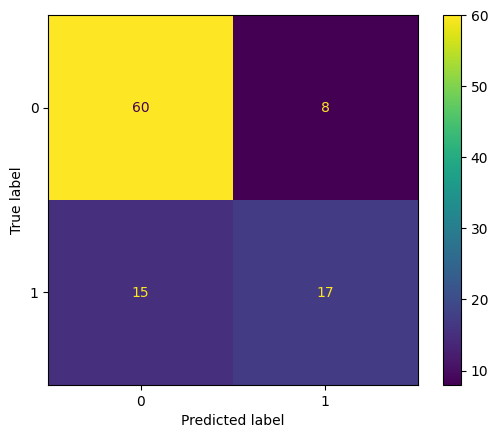

In [17]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

After this initial approach with test accuracy $76.4\%$, we will now prune the tree to select a more parsimonius model and avoid overfitting, especially since our training accuracy was $83.4\%$, which is much more than the test accuracy obtained. Trees have a tendency to overfit the data, and in fact using just a single split (depth 1 tree) we already obtain better results than from this naive model. We will now try to improve this.

In [18]:
clf_1 = tree.DecisionTreeClassifier(random_state=0)
path = clf_1.cost_complexity_pruning_path(train_input, train_target)
path

#cross_val_score(clf_1, train_input, train_target , cv=10)

{'ccp_alphas': array([0.        , 0.00446678, 0.00460637, 0.00469012, 0.00494661,
        0.00659966, 0.00670017, 0.00670017, 0.00703518, 0.00753769,
        0.00771702, 0.0080402 , 0.00820771, 0.00837521, 0.00846696,
        0.00871022, 0.00938023, 0.01007938, 0.01136022, 0.01183453,
        0.01376784, 0.03221465, 0.05263386, 0.05804441]),
 'impurities': array([0.        , 0.00893356, 0.01814629, 0.02752652, 0.03741974,
        0.07041806, 0.07711823, 0.0838184 , 0.10492393, 0.11246161,
        0.1510467 , 0.1590869 , 0.1672946 , 0.17566981, 0.20953767,
        0.22695811, 0.23633834, 0.2564971 , 0.26785732, 0.27969186,
        0.2934597 , 0.32567435, 0.37830821, 0.43635262])}

Text(0, 0.5, 'total impurity of leaves')

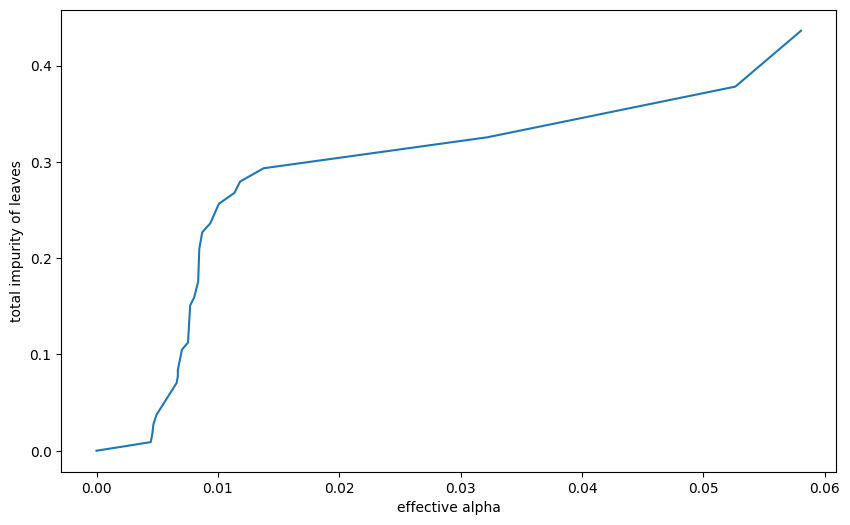

In [19]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

Text(0, 0.5, 'total depth')

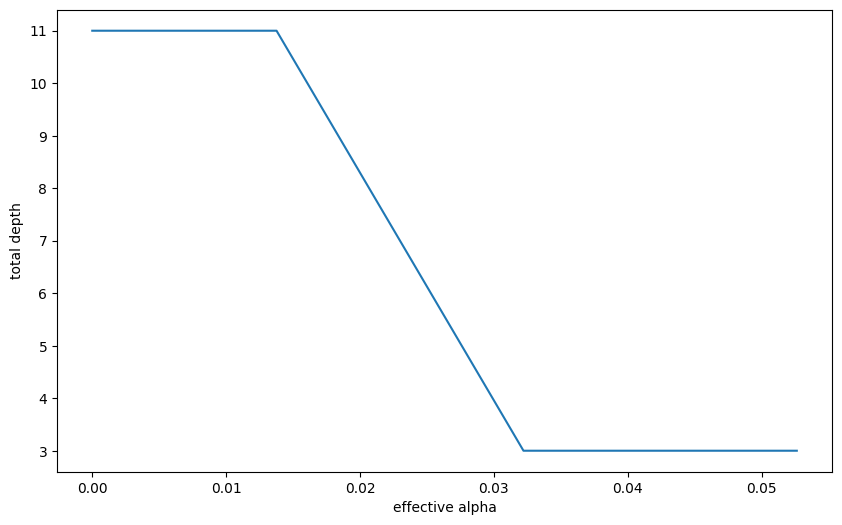

In [20]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(criterion='log_loss', random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_input, train_target)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

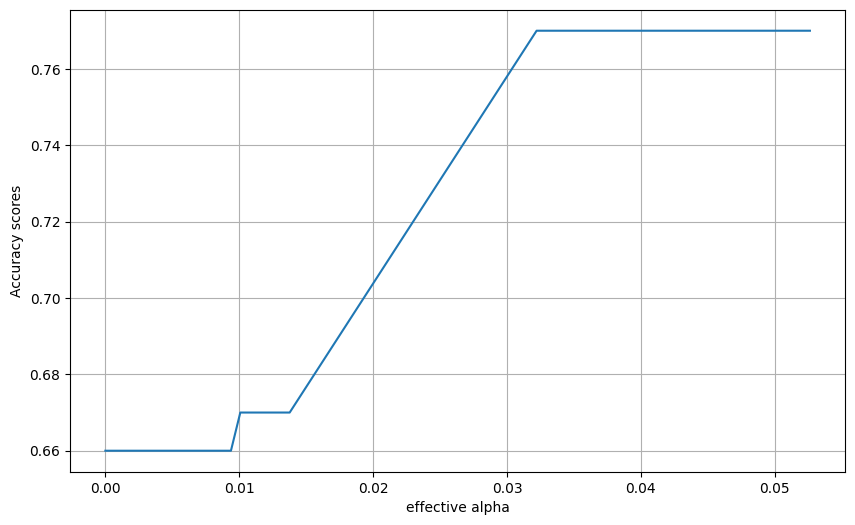

In [21]:
acc_scores = [accuracy_score(test_target, clf.predict(test_input)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

When `ccp_alpha` is set to zero and keeping the other default parameters of *DecisionTreeClassifier*, the tree overfits, leading to a much higher training accuracy than testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, an effective alpha between $0.03$ and $0.04$ yields the best possible choice.

In [22]:
aux = 0
for criterion in ['gini', 'entropy']:
    for splitter in ['best', 'random']:
        for max_depth in [1, 2, 3, 4, 5, 6, 7, 8]:
            # print(criterion, splitter, max_depth)
            clf = tree.DecisionTreeClassifier(criterion = criterion, splitter = splitter, max_depth = max_depth, random_state = 123)
            clf = clf.fit(train_input, train_target)
            train_pred = clf.predict(train_input)
            test_pred = clf.predict(test_input)
            train_acc = accuracy_score(train_target, train_pred);  #print(train_acc)
            test_acc = accuracy_score(test_target, test_pred);  #print(test_acc)
            if test_acc > aux:
                aux = test_acc
                combination = [criterion, splitter, max_depth]

print(aux)
print(combination)

0.8
['gini', 'best', 6]


In [23]:
clf_tree = tree.DecisionTreeClassifier(criterion = combination[0], splitter = combination[1], max_depth = combination[2], random_state = 123)
clf_tree = clf_tree.fit(train_input, train_target)

In [24]:
tree_final = clf_tree.fit(train_input, train_target)

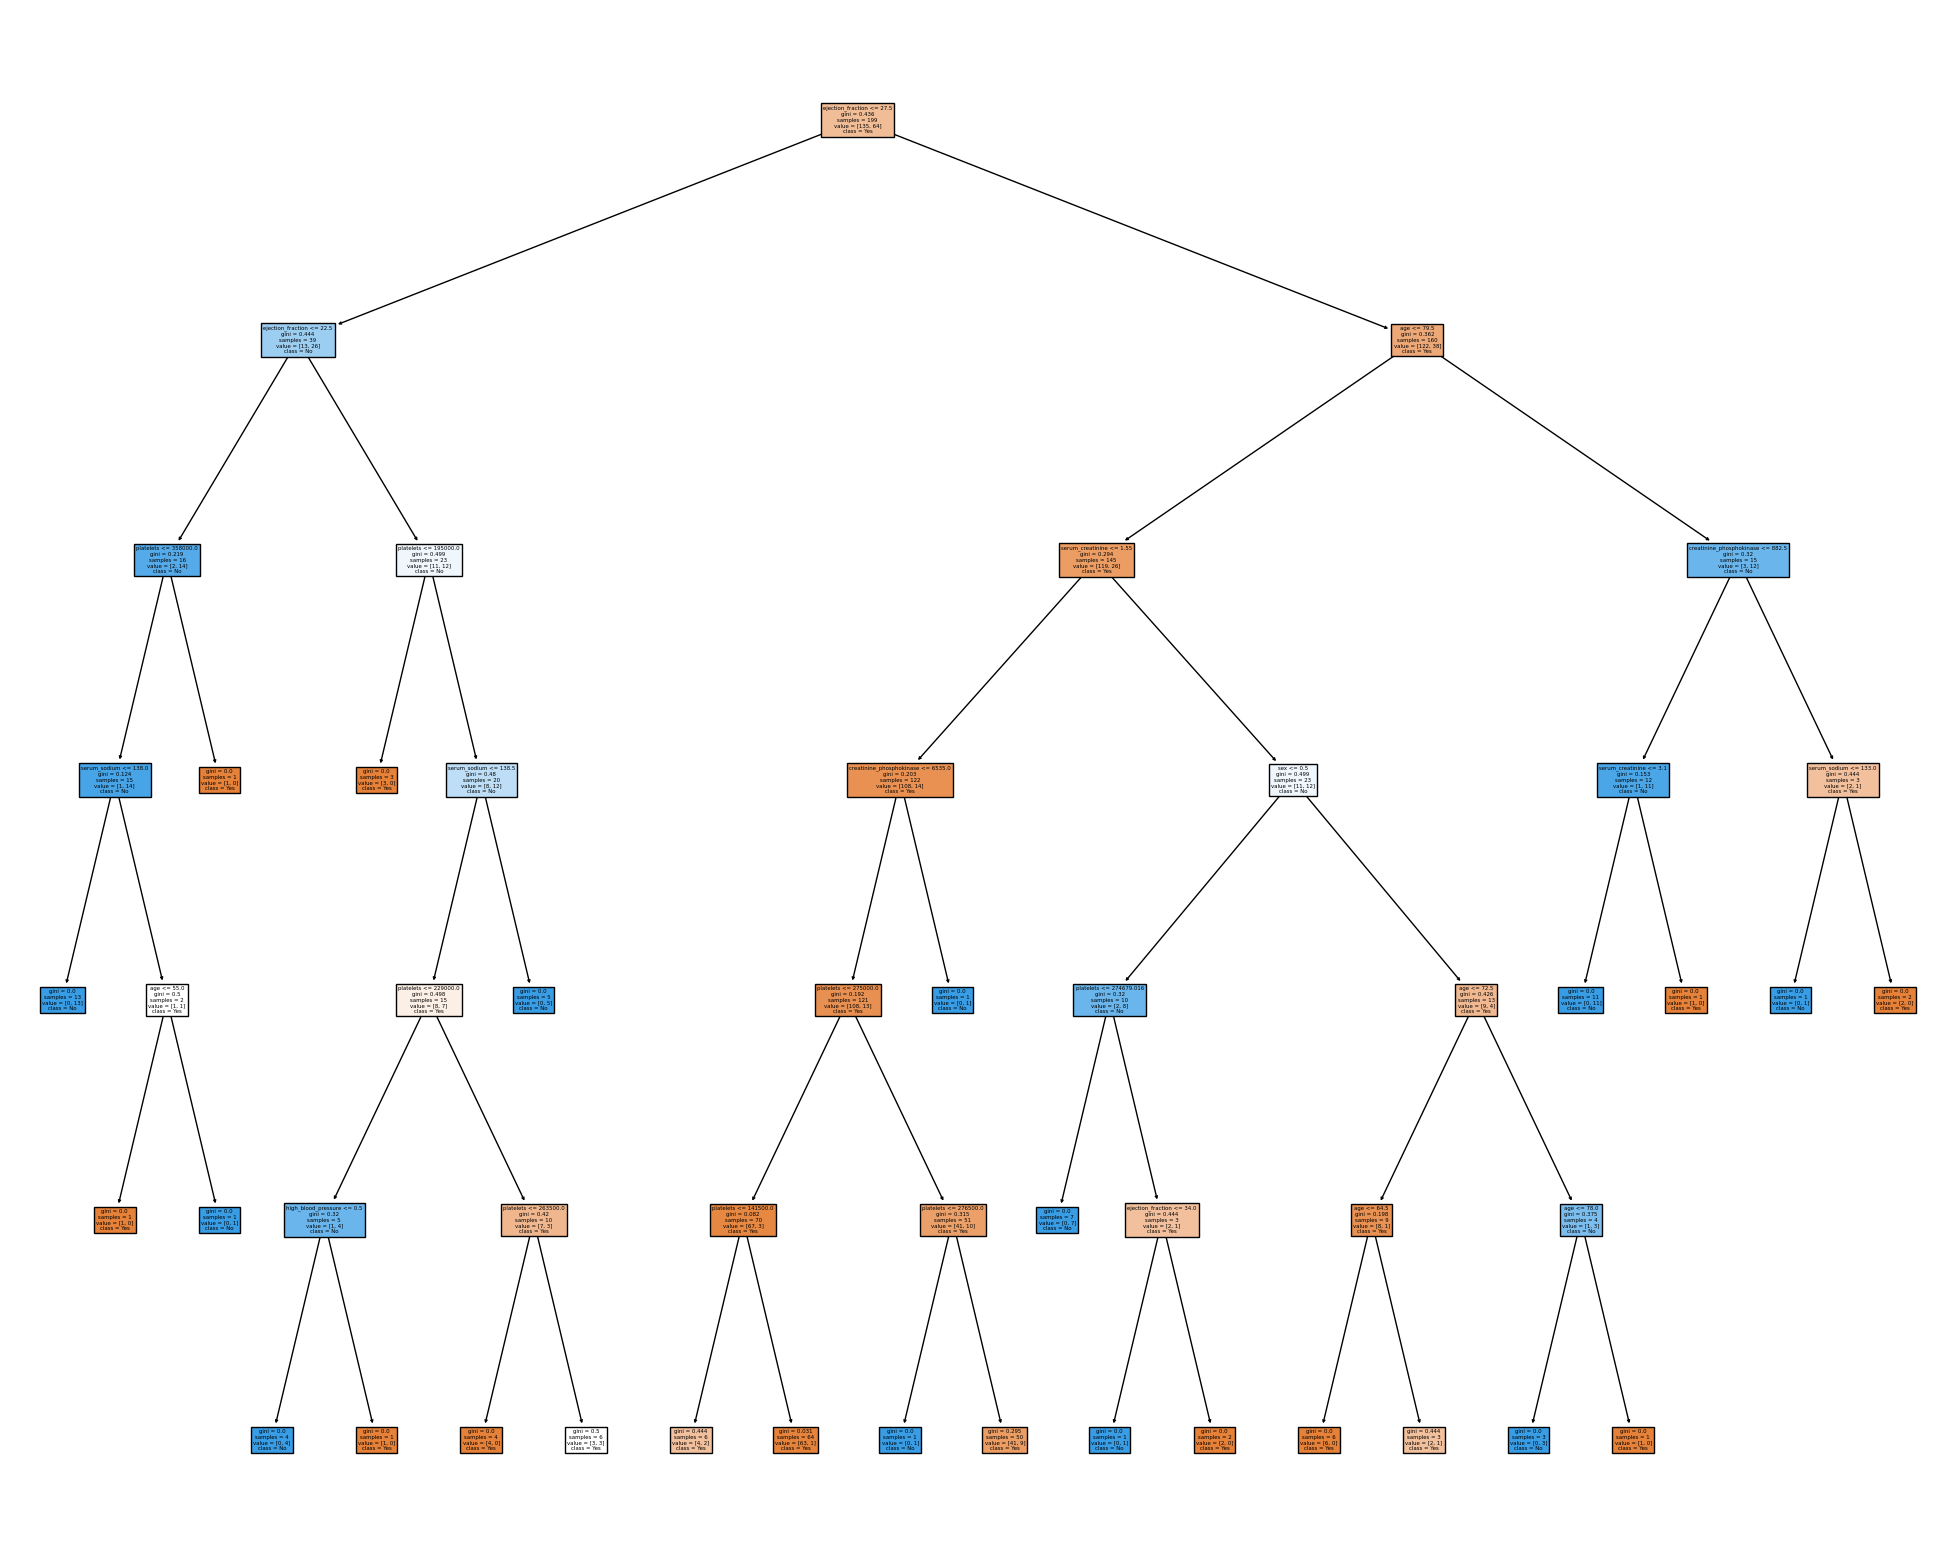

In [25]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_final, 
                   feature_names=train_input.columns,  
                   class_names=['Yes', 'No'],
                   filled=True)

0.8


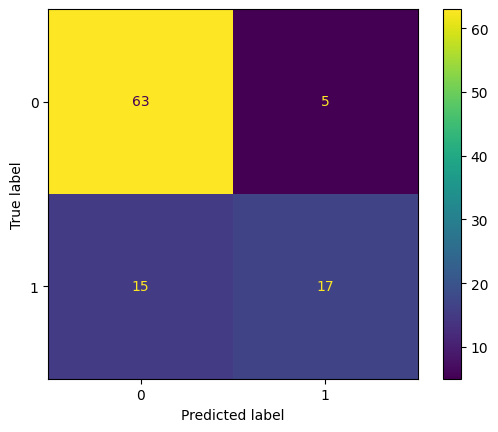

In [26]:
test_pred = clf_tree.predict(test_input)
print(accuracy_score(test_target, test_pred))
cm = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [27]:
importances = pd.DataFrame({'Predictor' : data.drop(columns = ['time', 'DEATH_EVENT']).columns,
              'Importance': clf_tree.feature_importances_})

importances.sort_values('Importance', ascending=False)

,Predictor,Importance
0,age,0.248461
4,ejection_fraction,0.241489
6,platelets,0.191047
7,serum_creatinine,0.130639
8,serum_sodium,0.068668
2,creatinine_phosphokinase,0.050924
9,sex,0.043416
5,high_blood_pressure,0.025354
1,anaemia,0.000000
3,diabetes,0.000000


From these metrics we conclude that the best decision tree for this dataset is the one stored in `clf_tree` as it is the one that performs the best on the test set 

### 3.2. Logistic regression

Now we will review one of the models from the first half of the course, namely a generalised linear model with the logistic function as its canonical link; logistic regression. Using the function from `sklearn` has the advantage that _ridge_, _lasso_ or _elasticnet_ regularisation is very easy to perform, as it is given as a parameter in the `LogisticRegression` class.

In [28]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(penalty='l2', solver='liblinear', random_state=0).fit(train_input, train_target)
test_pred = clf_logistic.predict(test_input)

print("Logistic regression accuracy:", accuracy_score(test_target, test_pred))

Logistic regression accuracy: 0.71


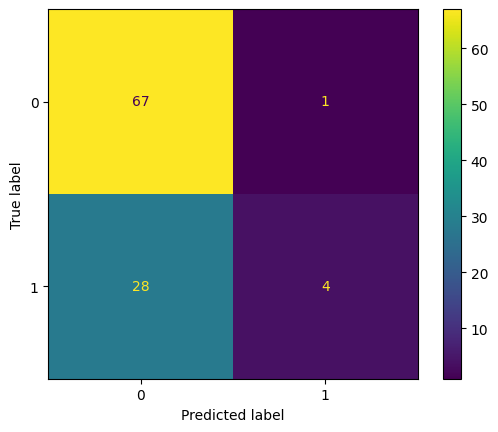

In [29]:
cm = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

As we may observe from the previous confusion matrix, the logistic regression tends to predict the most common class so we find many false negative errors. Its performance on the test set is of an $71\%$ accuracy and 

### 3.3. Support Vector Machines

Our choice for the third model is that of Support Vector Machines given that the data is high dimensional while non-linear, since a lot of the variables are boolean and the logistic regression's performance was not very impressive.

In [30]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_svm.fit(train_input, train_target)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

Naive SVM train accuracy: 0.9095477386934674
Naive SVM train accuracy: 0.68


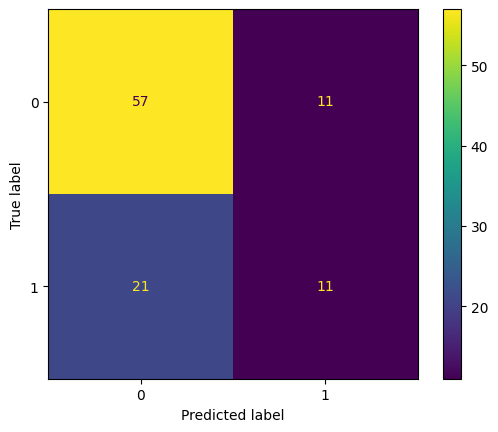

In [31]:
test_pred = clf_svm.predict(test_input)
print("Naive SVM train accuracy:", accuracy_score(train_target, clf_svm.predict(train_input)))
print("Naive SVM train accuracy:", accuracy_score(test_target, clf_svm.predict(test_input)))

cm = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

We can see how the support vector machine model overfits the data quite extensively since the training accuracy is $91.0\%$ while the test accuracy is only 

In [32]:
from sklearn.model_selection import StratifiedKFold

accuracies = []
params = []

skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(train_input.sort_index(), train_target.sort_index()):
    clf_svm.fit(train_input.iloc[train], train_target.iloc[train])
    test_pred = clf_svm.predict(train_input.iloc[test])
    accuracies.append(accuracy_score(test_pred, train_target.iloc[test]))
    params.append(clf_svm.get_params)
    print('train -  {}   |   test -  {}'.format(np.bincount(train_target.iloc[train]), np.bincount(train_target.iloc[test])))

print(accuracies)
params[3]

train -  [109  50]   |   test -  [26 14]
train -  [112  47]   |   test -  [23 17]
train -  [105  54]   |   test -  [30 10]
train -  [108  51]   |   test -  [27 13]
train -  [106  54]   |   test -  [29 10]
[0.8, 0.575, 0.75, 0.75, 0.6666666666666666]


<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])>

In [33]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(train_input, train_target)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'gamma': 0.001} with a score of 0.69


From the previous cell we may observe the best possible svm model after cross-validation, which is our finally selected model in this subsection.

SVM test accuracy: 0.73


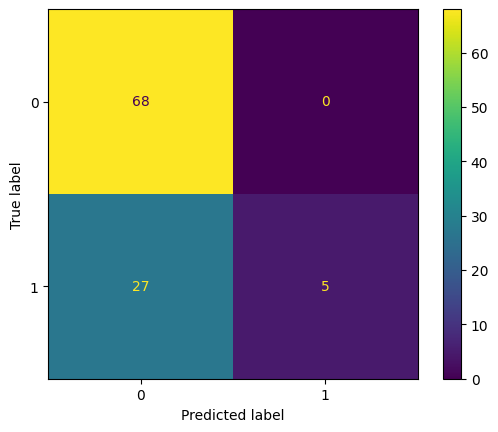

In [41]:
clf_svm = make_pipeline(StandardScaler(), SVC(C=10.0, gamma=0.001))
clf_svm.fit(train_input, train_target)

test_pred = clf_svm.predict(test_input)
print("SVM test accuracy:", accuracy_score(test_target, clf_svm.predict(test_input)))

cm = confusion_matrix(test_target, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

## 4. Model comparison

In [40]:
from sklearn.metrics import f1_score

test_pred_tree = clf_tree.predict(test_input)
test_pred_logistic = clf_logistic.predict(test_input)
test_pred_svm = clf_svm.predict(test_input)

print(print("Tree test Accuracy:", accuracy_score(test_target, test_pred_tree)))
print(print("Logistic test Accuracy:", accuracy_score(test_target, test_pred_logistic)))
print(print("SVM test F1 Accuracy:", accuracy_score(test_target, test_pred_svm)))

print(print("Tree test F1 Score:", f1_score(test_target, test_pred_tree)))
print(print("Logistic test F1 Score:", f1_score(test_target, test_pred_logistic)))
print(print("SVM test F1 Score:", f1_score(test_target, test_pred_svm)))

Tree test Accuracy: 0.8
None
Logistic test Accuracy: 0.71
None
SVM test F1 Accuracy: 0.73
None
Tree test F1 Score: 0.6296296296296297
None
Logistic test F1 Score: 0.21621621621621623
None
SVM test F1 Score: 0.2702702702702703
None


The poor F1 score for the logistic regression is of course due to its large amount of type 2 errors, so its recall is quite poor. Overall, the decision tree is the best performing model out of the three options.